# EEP 467 Homework 2: Breaking CAPTCHAs End-to-End

In lab 2, we have successfully built a pipeline that automatically recognizes CAPTCHAs. So far, the recognition process requires manually identifying contours (and subsequently bounding boxes) around characters using expert rules, before performing classification on extracted character images. This inspires us for possible further improvement: can we use a single neural network to directly identify CAPTCHA characters from CAPTCHA image? In this homework, we will get rid of bounding box identification and build an end-to-end neural network model.

## Before You Start

1. You can discuss on Discord if you have questions and want to seek help; however, please try your best to **limit the scope of your question** and **avoid asking directly for answers**. You should also **avoid copy-pasting answers and code** from others.
2. You are allowed to use AI assistants for help. In this case, you should **acknowledge your use of AI assistant** by providing its **name as well as how it helps you** to obtain your answer. Again, you **should not copy-paste from the response** of the AI assistant.

## Pre-processing

First of all, make sure you have installed all dependencies needed for this homework. The list of depedencies is similar to lab 3, except that we will ditch OpenCV and `imutils`, and instead use PyTorch Vision (`torchvision`) for some of our preprocessing work:

In [1]:
%pip install matplotlib scikit-learn tqdm

# If using Anaconda / Miniconda, install PyTorch and PyTorch Vision with:
# %conda install conda-forge::pytorch-gpu conda-forge::torchvision # (CPU and GPU support)
# %conda install conda-forge::pytorch conda-forge::torchvision # (CPU-only support)

# If using Pip, install PyTorch and PyTorch Vision with:
%pip install torch torchvision
# When installing PyTorch with GPU support, refer to https://pytorch.org/get-started/locally/
# if your CUDA version differs from the default CUDA version of the current version PyTorch package.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\redey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\redey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Once you are ready, we will start with data pre-processing step where we load all CAPTCHA images into memory. There are a few utilities in `torchvision` which can help us do the job:

In [2]:
import os

import torch
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.io import ImageReadMode, decode_image

# CAPTCHA images directory
CAPTCHA_IMAGES_DIR = "captcha-images"

# CAPTCHA images
captcha_images = []
# CAPTCHA texts
captcha_texts = []

## [ TODO ]
# 1) Load all CAPTCHA images from `CAPTCHA_IMAGES_DIR` into `captcha_images`
#    (Hint: use `os.scandir` to iterate over directory entries and check file extensions with `IMG_EXTENSIONS`)
#    (Hint: use `torchvision.io.decode_image` to load images in grayscale mode)
#    (Note: your code should ignore non-image files)
# 2) Stack all CAPTCHA images into a PyTorch tensor
# 3) Load all CAPTCHA texts (filenames without extension) into `captcha_texts`
#    (Items in `captcha_images` and `captcha_texts` should match)
entries = []
for entry in os.scandir(CAPTCHA_IMAGES_DIR):
    if not entry.is_file():
        continue
    _, ext = os.path.splitext(entry.name)
    if ext.lower() in IMG_EXTENSIONS:
        entries.append(entry)

# Sort by filename to keep deterministic ordering
entries.sort(key=lambda e: e.name)

images_list = []
texts_list = []
for entry in entries:
    img = decode_image(entry.path, mode=ImageReadMode.GRAY)  # (1, H, W), uint8
    images_list.append(img)
    texts_list.append(os.path.splitext(entry.name)[0])

captcha_images = torch.stack(images_list, dim=0)  # (N, 1, 24, 72)
captcha_texts = texts_list

Then, we split all CAPTCHA images and texts into training-validation and test sets:

In [3]:
from sklearn.model_selection import train_test_split

# Training-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Split dataset into training and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

Next, we encode each character in the CAPTCHA text as class indices:

In [4]:
from sklearn.preprocessing import LabelEncoder
import hw2_util

# Label encoder
le = LabelEncoder()

## [ TODO ]
# 1) Flatten training-validation CAPTCHA texts into list of characters
#    (Hint: `hw2_util.flatten` can help you with that)
# 2) Fit and transform characters into class indices using `LabelEncoder`
# 3) Save number of classes (distinct characters) in `n_classes`
# 4) Convert class indices to PyTorch tensor and reshape as `texts_class_indices_tv`
#    (The shape of `texts_class_indices_tv` should be (n_images, 4))
# Flatten list of captcha strings into list of characters
chars_tv = list(hw2_util.flatten([list(t) for t in captcha_texts_tv]))

# Fit and transform to class indices
chars_tv_idx = le.fit_transform(chars_tv)

# Number of unique character classes
n_classes = len(le.classes_)

# Convert to tensor and reshape to (n_images, 4)
texts_class_indices_tv = torch.as_tensor(chars_tv_idx, dtype=torch.long).reshape(len(captcha_texts_tv), 4)


Then, we further split training-validation set into two parts:

In [5]:
# Split training set further into training and validation sets
captcha_images_train, captcha_images_vali, texts_class_indices_train, texts_class_indices_vali = train_test_split(
    captcha_images_tv, texts_class_indices_tv, test_size=0.25, random_state=TVT_SPLIT_SEED
)

## Data Augmentation

The following step will be unique to this homework: we will perform **data augmentation** using PyTorch's [`transforms.Compose`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) and [`transforms.RandomAffine`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html). Here we will configure the `RandomAffine` transform to **apply the following random effects** to our CAPTCHAs:

* Random rotation (at most 5 degrees)
* Random horizontal and vertical shifting (at most 10%)
* Random shearing (at most 5 degrees)
* Random zooming in or out (at most 10%)

Besides, we will also **pre-process the image pixels** in the `RescaleInvertPixels` custom transform. Here we need to first **rescale the grayscale values** to $[0, 1]$ range and then **invert the grayscales**. We will chain the `RescaleInvertPixels` transform together with the `RandomAffine` transform using `Compose` to create a complete augmentation pipeline.

Below code will create such a transform pipeline, and preview its effects on a few sample CAPTCHAs:

Figure(2000x500)
Figure(2000x500)


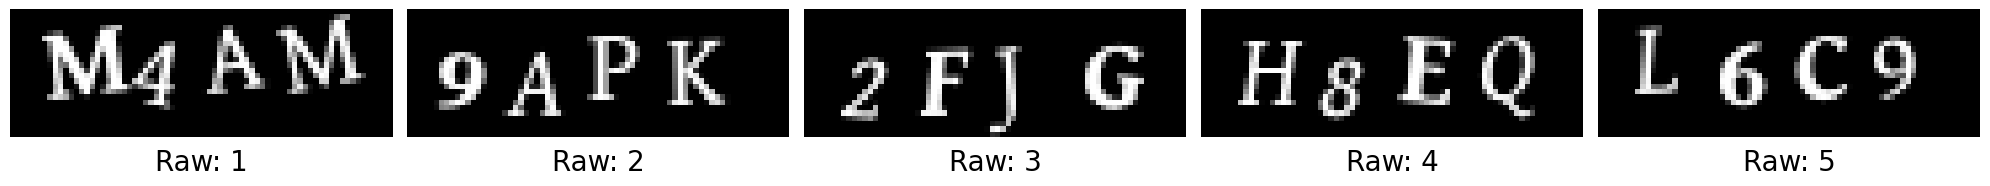

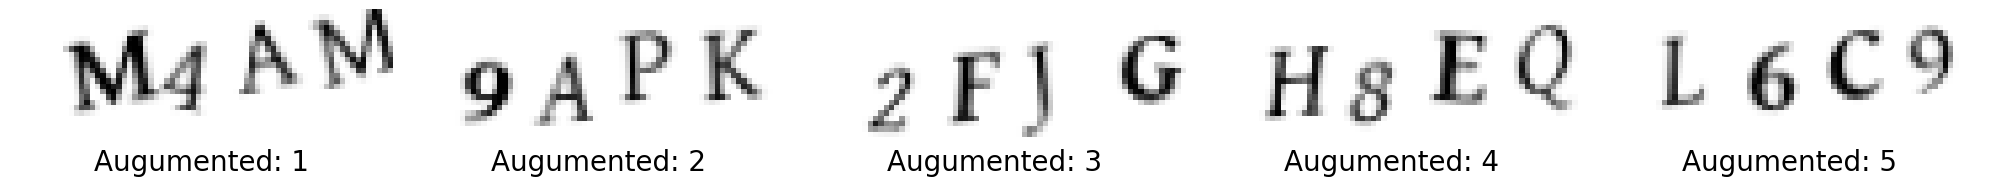

In [7]:
from torch import nn
from torchvision.transforms import Compose, InterpolationMode, RandomAffine

class RescaleInvertPixels(nn.Module):
    def forward(self, raw_image):
        ## [ TODO ]
        # 1) Rescale pixel grayscale values to [0, 1]
        # 2) Invert the grayscales of the image (darker becomes lighter, and vice versa)
        # 3) Return modified grayscales
        x = raw_image.to(dtype=torch.float32) / 255.0
        x = 1.0 - x
        return x

## [ TODO ]
# Create a transform pipeline using `Compose` with:
# 1) `RescaleInvertPixels()` for preprocessing
# 2) `RandomAffine` with the following random effects:
#    - Rotation: at most 5 degrees
#    - Horizontal and vertical shift: at most 10%
#    - Zooming: at most 10% (scale between 0.9 and 1.1)
#    - Shearing: at most 5 degrees
#    - Use `InterpolationMode.BILINEAR` for interpolation
#
# Choose parameters such that CAPTCHAs are moderately distorted but still recognizable.
captcha_transform = Compose([
    RescaleInvertPixels(),
    RandomAffine(
        degrees=5,
        translate=(0.10, 0.10),
        scale=(0.90, 1.10),
        shear=5,
        interpolation=InterpolationMode.BILINEAR
    )
])

# Select a few images for preview
preview_orig = captcha_images_train[:5]
# Generate a few transformed CAPTCHA images for preview
preview_trans = captcha_transform(preview_orig)

# Preview original and transformed CAPTCHAs
hw2_util.print_images(
    preview_orig.squeeze(-3),
    texts=[f"Raw: {i+1}" for i in range(5)]
)
hw2_util.print_images(
    preview_trans.squeeze(-3),
    texts=[f"Augumented: {i+1}" for i in range(5)]
)

Apart from the inversion of grayscale, you should be able to observe slight differences between original and transformed images. These transformed CAPTCHAs should still be easily recognizable, though.

## Training

From now on, we will shift our focus to the end-to-end neural network model. We assume our neural network model takes a bunch of CAPTCHA images (known as a batch) as input and outputs logits for each of the four character positions. In other words, if we have `n_classes` distinct characters in all CAPTCHAs, the output of our model would be a PyTorch tensor of shape `(batch_size, 4, n_classes)`. From each position's logits, we choose the character with the highest logit value (using the `argmax` operator), and we define a correct prediction as the one where all four characters are correctly predicted.

Our first task is to implement custom loss and accuracy functions for our task, since PyTorch's built-in functions expect different output formats. Both `pred_logits` (Raw model outputs) and `actual_class_indices` (Ground truth class indices) are batch tensors of shape `(batch_size, 4, n_classes)` and `(batch_size, 4)` respectively. Here we use PyTorch operations to compute our custom loss and accuracy metric:

In [8]:
from torch.nn import functional as f

def multi_char_loss(pred_logits, actual_class_indices):
    """ Compute the mean cross entropy loss of multiple CAPTCHA characters recognition. """
    return f.cross_entropy(pred_logits.flatten(0, 1), actual_class_indices.flatten())

def multi_char_acc(pred_logits, actual_class_indices):
    """ Compute the accuracy of multiple CAPTCHA characters recognition. """
    # Compute predicted class indices (most likely class / largest logits)
    pred_class_indices = pred_logits.argmax(-1)
    # Compute prediction accuracy for ALL four characters in a CAPTCHA, then average across samples
    return (pred_class_indices==actual_class_indices).all(-1).float().mean()

Next, we will complete `build_model` function which is responsible for building the neural network model. The neural network starts with several "convolution blocks" as usual, each of which contains a convolution layer for feature extraction and a max pooling layer for dimensionality reduction. The latter part of the network is however different from lab 3 in that **we replace regular fully-connected layers (implemented with linear layers) with "zone-wise" fully-connected layers (implemented with convolution layers)**.

We also substitute the regular cross-entropy loss for our custom `multi_char_loss` and make use of our custom accuracy metric, `multi_char_acc`, due to the unique output format of our model.

Below is the structure of our network:

In [10]:
from hw2_util import Transpose

def build_model(n_classes):
    """ Build the neural network model for CAPTCHA classification. """
    return nn.Sequential(
        # First convolution block: (*, 1, 24, 72) -Conv2d-> (*, 10, 24, 72) -ReLU-> (*, 10, 24, 72) -MaxPool2d-> (*, 10, 12, 36)
        nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ),
        # Second convolution block: (*, 10, 12, 36) -Conv2d-> (*, 40, 12, 36) -ReLU-> (*, 40, 12, 36) -MaxPool2d-> (*, 40, 6, 18)
        nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=40, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ),
        # Third convolution block: (*, 40, 6, 18) -Conv2d-> (*, 100, 6, 18) -ReLU-> (*, 100, 6, 18) -MaxPool2d-> (*, 100, 3, 9)
        nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ),
        # First "zone-wise" fully-connected block: (*, 100, 3, 9) -Conv2d-> (*, 800, 1, 4) -ReLU-> (*, 800, 1, 4)
        nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=800, kernel_size=3, stride=(1, 2), padding=0),
            nn.ReLU()
        ),
        # Second "zone-wise" fully-connected layer: (*, 800, 1, 4) -Conv2d-> (*, n_classes, 1, 4)
        nn.Conv2d(in_channels=800, out_channels=n_classes, kernel_size=1, padding=0),
        # Reshape and transpose dimensions: (*, n_classes, 1, 4) -Flatten-> (*, n_classes, 4) -Transpose-> (*, 4, n_classes)
        nn.Sequential(
            nn.Flatten(start_dim=2),
            Transpose(1, 2)
        )
    )

To facilitate efficient data loading and transformation, we will create a custom PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class called `CAPTCHADataset`. This class will handle loading CAPTCHA images and their corresponding labels, and apply the data augmentation transforms on-the-fly during training. By implementing the standard PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) interface, we can leverage PyTorch's [`DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for efficient batch processing and parallel data loading:

In [11]:
from torch.utils.data import Dataset

class CAPTCHADataset(Dataset):
    def __init__(self, captcha_images, texts_features, captcha_transform):
        self.captcha_images = captcha_images
        self.texts_features = texts_features
        self.captcha_transform = captcha_transform

    def __len__(self):
        return len(self.captcha_images)

    def __getitem__(self, idx):
        captcha_image = self.captcha_transform(self.captcha_images[idx])
        text_features = self.texts_features[idx]

        return captcha_image, text_features

Finally, the `train_model` function implements the standard PyTorch training loop. For each epoch, it performs forward passes on batches from the training set, computes loss using `multi_char_loss`, backpropagates gradients, and updates model parameters. After each epoch, it evaluates the model on the validation set. Data augmentation is applied on-the-fly via the `CAPTCHADataset` during both training and validation.

In [12]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_model(model, optimizer, dataset_train, dataset_vali, batch_size=32, n_epochs=50, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # 1) Create training data loader from `dataset_train` with shuffling enabled
    # 2) Create validation data loader from `dataset_vali`
    # (Note: set the batch size for both loaders)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_vali = DataLoader(dataset_vali, batch_size=batch_size, shuffle=False)

    history = []

    print("Starting training ...")
    for i in range(n_epochs):
        # In every epoch, do training first ...
        loss_train = 0.
        acc_train = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_train):
            ## [ TODO ]
            # Complete the training inner loop:
            #
            # 1) Move images and labels to the target device
            # 2) Perform forward pass to get logits
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            # 4) Perform backward propagation
            # 5) Update model parameters by taking an optimizer step
            # 6) Clear model gradients
            # 7) Accumulate loss and accuracy
            #    (Hint: Detach loss tensor before accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            captcha_images_batch = captcha_images_batch.to(device)
            texts_class_indices_batch = texts_class_indices_batch.to(device)

            pred_logits = model(captcha_images_batch)

            loss = multi_char_loss(pred_logits, texts_class_indices_batch)
            acc = multi_char_acc(pred_logits, texts_class_indices_batch)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            loss_train += loss.detach().cpu()
            acc_train += acc.detach().cpu()

        loss_train = (loss_train/len(loader_train)).item()
        acc_train = (acc_train/len(loader_train)).item()
        # Report loss and metrics
        print(f"Ending training of epoch {i+1}/{n_epochs}: loss: {loss_train}, accuracy: {acc_train}")

        # Then evaluate the model
        loss_vali = 0.
        acc_vali = 0.

        # Put model in validation mode
        model.eval()

        print(f"Starting validation epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_vali):
            ## [ TODO ]
            # Complete the validation inner loop:
            #
            # 1) Move images and labels to the target device
            # 2) Perform forward pass to get logits
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            # 4) Accumulate loss and accuracy (move tensors to CPU for accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            with torch.no_grad():
                captcha_images_batch = captcha_images_batch.to(device)
                texts_class_indices_batch = texts_class_indices_batch.to(device)

                pred_logits = model(captcha_images_batch)
                loss = multi_char_loss(pred_logits, texts_class_indices_batch)
                acc = multi_char_acc(pred_logits, texts_class_indices_batch)

            loss_vali += loss.detach().cpu()
            acc_vali += acc.detach().cpu()

        loss_vali = (loss_vali/len(loader_vali)).item()
        acc_vali = (acc_vali/len(loader_vali)).item()
        # Report loss and metrics
        print(f"Ending validation of epoch {i+1}/{n_epochs}: loss: {loss_vali}, accuracy: {acc_vali}")

        # Save epoch metrics
        history.append({
            "epoch": i+1,
            "loss_train": loss_train,
            "acc_train": acc_train,
            "loss_vali": loss_vali,
            "acc_vali": acc_vali
        })

        # Put model back in training mode
        model.train()

    return history

Ok, it's time to put everything together. We will build our model, train our model for some epochs and save it as `model-basic-params.pt`. For model training, you may adjust the number of epochs and / or batch size if necessary, to ensure that you achieve at least 80% of accuracy on the training set and at least 70% of accuracy on the validation set.

In [13]:
from torch.optim import AdamW

# Detect best PyTorch device
# (Prefer GPU devices such as CUDA or MPS, then fall back to CPU as last resort)
torch_device = hw2_util.get_torch_device()

# Build training and validation datasets
dataset_train = CAPTCHADataset(captcha_images_train, texts_class_indices_train, captcha_transform)
dataset_vali = CAPTCHADataset(captcha_images_vali, texts_class_indices_vali, captcha_transform)

# Build a basic end-to-end CAPTCHA model
model_basic = build_model(n_classes)
# Move model to PyTorch device
model_basic = model_basic.to(torch_device)
# Build an AdamW optimizer with model parameters
optimizer = AdamW(model_basic.parameters(), lr=0.001)

# Show model structure
print("Model structure:")
print(model_basic)
print()

# Train the basic model for 100 epochs
history_basic = train_model(model_basic, optimizer, dataset_train, dataset_vali)
# Save the basic model in file
torch.save(model_basic.state_dict(), "./model-basic-params.pt")

Model structure:
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(10, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(40, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2))
    (1): ReLU()
  )
  (4): Conv2d(800, 32, kernel_size=(1, 1), stride=(1, 1))
  (5): Sequential(
    (0): Flatten(start_dim=2, end_dim=-1)
    (1): Transpose(dim0=1, dim1=2)
  )
)

Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:01<00:00, 18.95it/s]


Ending training of epoch 1/50: loss: 3.41203236579895, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 34.33it/s]


Ending validation of epoch 1/50: loss: 3.337135076522827, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:01<00:00, 20.41it/s]


Ending training of epoch 2/50: loss: 3.248164176940918, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.57it/s]


Ending validation of epoch 2/50: loss: 3.0909533500671387, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.82it/s]


Ending training of epoch 3/50: loss: 2.9984452724456787, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 41.21it/s]


Ending validation of epoch 3/50: loss: 2.796322822570801, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.76it/s]


Ending training of epoch 4/50: loss: 2.716188669204712, accuracy: 0.0
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 39.78it/s]


Ending validation of epoch 4/50: loss: 2.5337729454040527, accuracy: 0.0078125
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.65it/s]


Ending training of epoch 5/50: loss: 2.3738996982574463, accuracy: 0.005681818351149559
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 31.02it/s]


Ending validation of epoch 5/50: loss: 2.249948501586914, accuracy: 0.01171875
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:01<00:00, 20.57it/s]


Ending training of epoch 6/50: loss: 1.9421426057815552, accuracy: 0.02130681835114956
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 36.09it/s]


Ending validation of epoch 6/50: loss: 1.8241863250732422, accuracy: 0.03515625
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.09it/s]


Ending training of epoch 7/50: loss: 1.6751453876495361, accuracy: 0.07244317978620529
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 39.48it/s]


Ending validation of epoch 7/50: loss: 1.5464928150177002, accuracy: 0.08203125
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.11it/s]


Ending training of epoch 8/50: loss: 1.4084446430206299, accuracy: 0.118055559694767
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 33.46it/s]


Ending validation of epoch 8/50: loss: 1.292223572731018, accuracy: 0.1705729216337204
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.17it/s]


Ending training of epoch 9/50: loss: 1.2350572347640991, accuracy: 0.2239583432674408
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 37.25it/s]


Ending validation of epoch 9/50: loss: 1.251643180847168, accuracy: 0.234375
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.74it/s]


Ending training of epoch 10/50: loss: 1.0871974229812622, accuracy: 0.3147096037864685
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 41.60it/s]


Ending validation of epoch 10/50: loss: 0.963285505771637, accuracy: 0.3151041567325592
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.08it/s]


Ending training of epoch 11/50: loss: 0.872893750667572, accuracy: 0.38226011395454407
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 36.16it/s]


Ending validation of epoch 11/50: loss: 0.9666800498962402, accuracy: 0.3346354067325592
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:01<00:00, 18.47it/s]


Ending training of epoch 12/50: loss: 0.7277311086654663, accuracy: 0.4493371248245239
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 37.02it/s]


Ending validation of epoch 12/50: loss: 0.9164609909057617, accuracy: 0.3893229067325592
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:01<00:00, 19.67it/s]


Ending training of epoch 13/50: loss: 0.7365400195121765, accuracy: 0.49763259291648865
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 39.27it/s]


Ending validation of epoch 13/50: loss: 0.7192453145980835, accuracy: 0.4739583432674408
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.25it/s]


Ending training of epoch 14/50: loss: 0.6859322786331177, accuracy: 0.544349730014801
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 40.88it/s]


Ending validation of epoch 14/50: loss: 0.6360099911689758, accuracy: 0.5481770634651184
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:01<00:00, 19.91it/s]


Ending training of epoch 15/50: loss: 0.5858226418495178, accuracy: 0.5950126051902771
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 40.32it/s]


Ending validation of epoch 15/50: loss: 0.7133440971374512, accuracy: 0.5520833134651184
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.50it/s]


Ending training of epoch 16/50: loss: 0.5755032896995544, accuracy: 0.5992739796638489
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 40.85it/s]


Ending validation of epoch 16/50: loss: 0.5478062629699707, accuracy: 0.625
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.06it/s]


Ending training of epoch 17/50: loss: 0.5535520911216736, accuracy: 0.5935921669006348
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.52it/s]


Ending validation of epoch 17/50: loss: 0.527431309223175, accuracy: 0.66015625
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.91it/s]


Ending training of epoch 18/50: loss: 0.5218148231506348, accuracy: 0.5999053120613098
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 46.79it/s]


Ending validation of epoch 18/50: loss: 0.5851883292198181, accuracy: 0.61328125
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.35it/s]


Ending training of epoch 19/50: loss: 0.48938867449760437, accuracy: 0.6603535413742065
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.68it/s]


Ending validation of epoch 19/50: loss: 0.42821192741394043, accuracy: 0.66015625
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 23.39it/s]


Ending training of epoch 20/50: loss: 0.4284992218017578, accuracy: 0.6835542917251587
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.49it/s]


Ending validation of epoch 20/50: loss: 0.46170204877853394, accuracy: 0.6796875
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.86it/s]


Ending training of epoch 21/50: loss: 0.47276535630226135, accuracy: 0.6680871248245239
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.81it/s]


Ending validation of epoch 21/50: loss: 0.5196213126182556, accuracy: 0.5533854365348816
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.91it/s]


Ending training of epoch 22/50: loss: 0.39577433466911316, accuracy: 0.6930239796638489
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.43it/s]


Ending validation of epoch 22/50: loss: 0.4673789441585541, accuracy: 0.6653645634651184
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.22it/s]


Ending training of epoch 23/50: loss: 0.40015754103660583, accuracy: 0.7327967286109924
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 41.30it/s]


Ending validation of epoch 23/50: loss: 0.3907017409801483, accuracy: 0.6888020634651184
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.37it/s]


Ending training of epoch 24/50: loss: 0.35912632942199707, accuracy: 0.7342172265052795
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.93it/s]


Ending validation of epoch 24/50: loss: 0.44788306951522827, accuracy: 0.72265625
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.72it/s]


Ending training of epoch 25/50: loss: 0.40489357709884644, accuracy: 0.720643937587738
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.03it/s]


Ending validation of epoch 25/50: loss: 0.38641589879989624, accuracy: 0.75
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 23.21it/s]


Ending training of epoch 26/50: loss: 0.3087771236896515, accuracy: 0.767518937587738
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.24it/s]


Ending validation of epoch 26/50: loss: 0.5100377798080444, accuracy: 0.6666666865348816
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.57it/s]


Ending training of epoch 27/50: loss: 0.31802988052368164, accuracy: 0.771780252456665
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 32.84it/s]


Ending validation of epoch 27/50: loss: 0.4390146732330322, accuracy: 0.70703125
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 23.56it/s]


Ending training of epoch 28/50: loss: 0.31921422481536865, accuracy: 0.7555240392684937
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.00it/s]


Ending validation of epoch 28/50: loss: 0.4006485044956207, accuracy: 0.6549479365348816
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.75it/s]


Ending training of epoch 29/50: loss: 0.2911446690559387, accuracy: 0.8003472685813904
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.88it/s]


Ending validation of epoch 29/50: loss: 0.3738127648830414, accuracy: 0.7161458134651184
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.12it/s]


Ending training of epoch 30/50: loss: 0.30182650685310364, accuracy: 0.7768308520317078
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 45.93it/s]


Ending validation of epoch 30/50: loss: 0.33079206943511963, accuracy: 0.7395833134651184
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.92it/s]


Ending training of epoch 31/50: loss: 0.3066052198410034, accuracy: 0.7952967286109924
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.66it/s]


Ending validation of epoch 31/50: loss: 0.4230954051017761, accuracy: 0.6588541865348816
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.94it/s]


Ending training of epoch 32/50: loss: 0.2558959126472473, accuracy: 0.8301767706871033
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.19it/s]


Ending validation of epoch 32/50: loss: 0.3315957486629486, accuracy: 0.6901041865348816
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.66it/s]


Ending training of epoch 33/50: loss: 0.2713339626789093, accuracy: 0.8095012903213501
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.75it/s]


Ending validation of epoch 33/50: loss: 0.3234436810016632, accuracy: 0.7734375
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.45it/s]


Ending training of epoch 34/50: loss: 0.25214534997940063, accuracy: 0.803819477558136
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.60it/s]


Ending validation of epoch 34/50: loss: 0.25344568490982056, accuracy: 0.79296875
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.23it/s]


Ending training of epoch 35/50: loss: 0.2662753760814667, accuracy: 0.8309659361839294
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.77it/s]


Ending validation of epoch 35/50: loss: 0.4493964910507202, accuracy: 0.6979166865348816
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:01<00:00, 20.88it/s]


Ending training of epoch 36/50: loss: 0.2398635745048523, accuracy: 0.8295454382896423
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 42.57it/s]


Ending validation of epoch 36/50: loss: 0.3183996081352234, accuracy: 0.74609375
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.74it/s]


Ending training of epoch 37/50: loss: 0.19191886484622955, accuracy: 0.8409090638160706
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.51it/s]


Ending validation of epoch 37/50: loss: 0.3605102598667145, accuracy: 0.76953125
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.20it/s]


Ending training of epoch 38/50: loss: 0.24054290354251862, accuracy: 0.8088699579238892
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.71it/s]


Ending validation of epoch 38/50: loss: 0.2931027412414551, accuracy: 0.7578125
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.25it/s]


Ending training of epoch 39/50: loss: 0.24089592695236206, accuracy: 0.8202335834503174
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 45.97it/s]


Ending validation of epoch 39/50: loss: 0.30080071091651917, accuracy: 0.7083333134651184
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.99it/s]


Ending training of epoch 40/50: loss: 0.22159656882286072, accuracy: 0.8237058520317078
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.89it/s]


Ending validation of epoch 40/50: loss: 0.2751271724700928, accuracy: 0.7747395634651184
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.33it/s]


Ending training of epoch 41/50: loss: 0.2544195055961609, accuracy: 0.8058711886405945
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


Ending validation of epoch 41/50: loss: 0.40103867650032043, accuracy: 0.70703125
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.96it/s]


Ending training of epoch 42/50: loss: 0.26710355281829834, accuracy: 0.8025568127632141
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 35.15it/s]


Ending validation of epoch 42/50: loss: 0.2965269088745117, accuracy: 0.7356770634651184
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.94it/s]


Ending training of epoch 43/50: loss: 0.22610636055469513, accuracy: 0.8230745196342468
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.38it/s]


Ending validation of epoch 43/50: loss: 0.30551934242248535, accuracy: 0.7890625
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.44it/s]


Ending training of epoch 44/50: loss: 0.2060045748949051, accuracy: 0.8579545617103577
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.94it/s]


Ending validation of epoch 44/50: loss: 0.2737768292427063, accuracy: 0.79296875
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.37it/s]


Ending training of epoch 45/50: loss: 0.1948215514421463, accuracy: 0.8470643758773804
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 45.66it/s]


Ending validation of epoch 45/50: loss: 0.31895411014556885, accuracy: 0.7434895634651184
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.12it/s]


Ending training of epoch 46/50: loss: 0.21554650366306305, accuracy: 0.8358585834503174
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.66it/s]


Ending validation of epoch 46/50: loss: 0.30308523774147034, accuracy: 0.7473958134651184
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.98it/s]


Ending training of epoch 47/50: loss: 0.22972077131271362, accuracy: 0.8429608941078186
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.04it/s]


Ending validation of epoch 47/50: loss: 0.31057441234588623, accuracy: 0.7278645634651184
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:01<00:00, 20.44it/s]


Ending training of epoch 48/50: loss: 0.18840807676315308, accuracy: 0.8435922265052795
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 30.30it/s]


Ending validation of epoch 48/50: loss: 0.2524397671222687, accuracy: 0.82421875
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:01<00:00, 21.89it/s]


Ending training of epoch 49/50: loss: 0.176025852560997, accuracy: 0.8458017706871033
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 43.81it/s]


Ending validation of epoch 49/50: loss: 0.2744147777557373, accuracy: 0.7643229365348816
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 22.60it/s]


Ending training of epoch 50/50: loss: 0.1678219437599182, accuracy: 0.8827335834503174
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 44.07it/s]


Ending validation of epoch 50/50: loss: 0.3080129027366638, accuracy: 0.76953125


## Evaluation

We have obtained a trained model as well as the training history during the previous stage. The training history contains the loss and accuracy of the nerual network as the training process proceeded. To show their trend during training, we plot these metrics for both training and validation set:

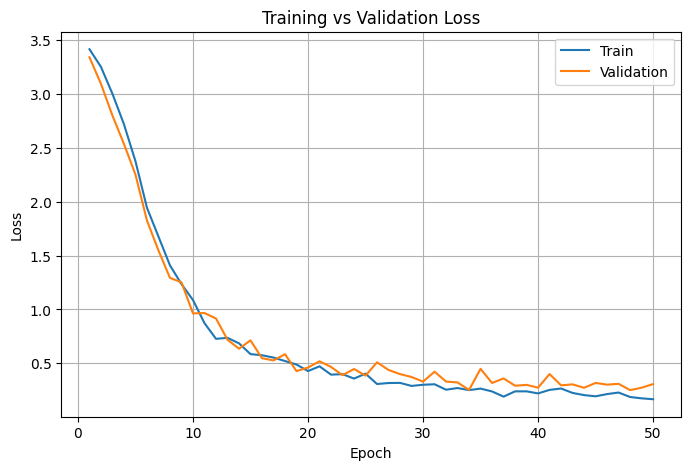

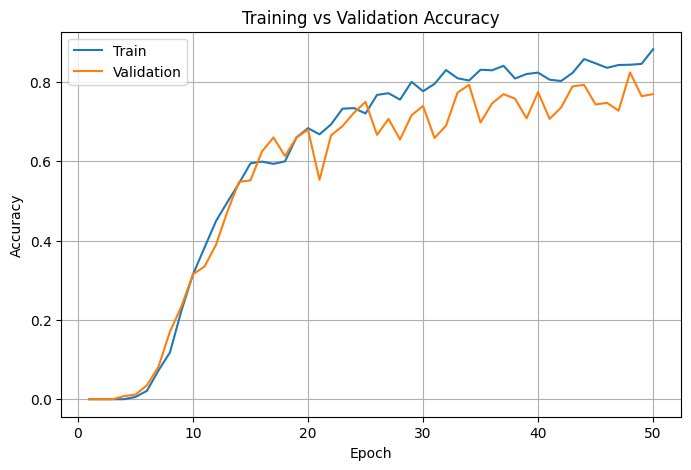

In [14]:
from matplotlib import pyplot as plt

## [ TODO ]
# 1) Plot the loss of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training loss is `history[epoch]["loss_train"]` and `history[epoch]["loss_vali"]`)
# 2) Plot the accuracy of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training accuracy is `history[epoch]["acc_train"]` and `history[epoch]["acc_vali"]`)
#    (Note: plot all curves for the same metric on the same graph for comparison)
epochs = [h["epoch"] for h in history_basic]

loss_train = [h["loss_train"] for h in history_basic]
loss_vali = [h["loss_vali"] for h in history_basic]

acc_train = [h["acc_train"] for h in history_basic]
acc_vali = [h["acc_vali"] for h in history_basic]

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_train, label="Train")
plt.plot(epochs, loss_vali, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc_train, label="Train")
plt.plot(epochs, acc_vali, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

Next, we evaluate our model end-to-end on the test set. Like training and validation set, we transform test set CAPTCHA images through data augmentation. We then predict the characters for these images and compare the predictions with ground truth. Similar to lab 3, we compute the accuracy of our model and show samples of correct and incorrect predictions:

In [21]:
def evaluate_model(model, le, dataset_eval, batch_size=32, n_epochs=5, n_display_samples=10, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # Create evaluation data loader from `dataset_eval`
    # (Note: set the batch size)
    loader_eval = DataLoader(dataset_eval, batch_size=batch_size, shuffle=False)

    # Number of test samples and correct predictions
    n_test = n_correct = 0
    # Correct and incorrect samples
    correct_samples = []
    incorrect_samples = []

    # Put model in validation mode
    model.eval()

    for i in range(n_epochs):
        # In every epoch, do training first ...
        print(f"Starting evaluation epoch {i+1}/{n_epochs} ...")
        for images_batch, texts_batch in tqdm(loader_eval):
            # Make a copy of images batch on target PyTorch device, while keeping original batch on CPU
            images_batch_device = images_batch.to(device)

            ## [ TODO ]
            # 1) Predict characters with neural network model
            # 2) Flatten and move predictions to CPU
            # 3) Decode predicted class indices back to characters using `LabelEncoder.inverse_transform`
            # 4) Group every 4 characters together to form predicted CAPTCHAs
            #    (Hint: `hw2_util.group_every` can help with grouping)
            # 5) For each CAPTCHA, its prediction and actual text:
            #    - Update number of correct predictions
            #    - Collect `n_display_samples` correct samples of tuple (image, prediction) for review
            #    - Collect `n_display_samples` incorrect samples of tuple (image, prediction, actual) for review
            #      (Caution: DO NOT print ALL correct / incorrect images; this is slow and the output will be messy!)
            with torch.no_grad():
                pred_logits = model(images_batch_device)
                pred_idx = pred_logits.argmax(dim=-1)  # (B, 4)

            pred_idx_flat = pred_idx.reshape(-1).detach().cpu().numpy()
            pred_chars = le.inverse_transform(pred_idx_flat)
            pred_texts = ["".join(group) for group in hw2_util.group_every(pred_chars, n_elem=4)]

            for img, pred_text, actual_text in zip(images_batch, pred_texts, texts_batch):
                n_test += 1

                # Convert image from (1, H, W) -> (H, W) for matplotlib imshow
                img2d = img.squeeze(0)

                if pred_text == actual_text:
                    n_correct += 1
                    if len(correct_samples) < n_display_samples:
                        # store (image, actual) for "Correct" display
                        correct_samples.append((img2d, actual_text))
                else:
                    if len(incorrect_samples) < n_display_samples:
                        # store (image, pred, actual) for "Incorrect" display
                        incorrect_samples.append((img2d, pred_text, actual_text))
                        
        # Report loss and metrics
        print(f"Ending evaluation of epoch {i+1}/{n_epochs} ...")

    # Put model back in training mode
    model.train()

    # Show statistics
    print()
    print("# of test CAPTCHAs:", n_test)
    print("# correctly recognized:", n_correct)
    print("Accuracy:", n_correct/n_test, "\n")

    assert len(correct_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} correct samples as examples!"
    assert len(incorrect_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} incorrect samples as examples!"

    # Show all correct predictions
    hw2_util.print_images(
        hw2_util.unzip(correct_samples)[0],
        texts=[f"Correct: {actual}" for _, actual in correct_samples],
        n_rows=2
    )

    # Show all incorrect predictions
    hw2_util.print_images(
        hw2_util.unzip(incorrect_samples)[0],
        texts=[
            f"Prediction: {pred}\nActual: {actual}" \
            for _, pred, actual in incorrect_samples
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )

Now we run the evaluation process on the basic model:

Starting evaluation epoch 1/5 ...


100%|██████████| 8/8 [00:00<00:00, 36.43it/s]


Ending evaluation of epoch 1/5 ...
Starting evaluation epoch 2/5 ...


100%|██████████| 8/8 [00:00<00:00, 36.09it/s]


Ending evaluation of epoch 2/5 ...
Starting evaluation epoch 3/5 ...


100%|██████████| 8/8 [00:00<00:00, 36.26it/s]


Ending evaluation of epoch 3/5 ...
Starting evaluation epoch 4/5 ...


100%|██████████| 8/8 [00:00<00:00, 39.58it/s]


Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 5/5 ...


100%|██████████| 8/8 [00:00<00:00, 41.61it/s]


Ending evaluation of epoch 5/5 ...

# of test CAPTCHAs: 1140
# correctly recognized: 891
Accuracy: 0.781578947368421 

Figure(2000x500)
Figure(2000x600)


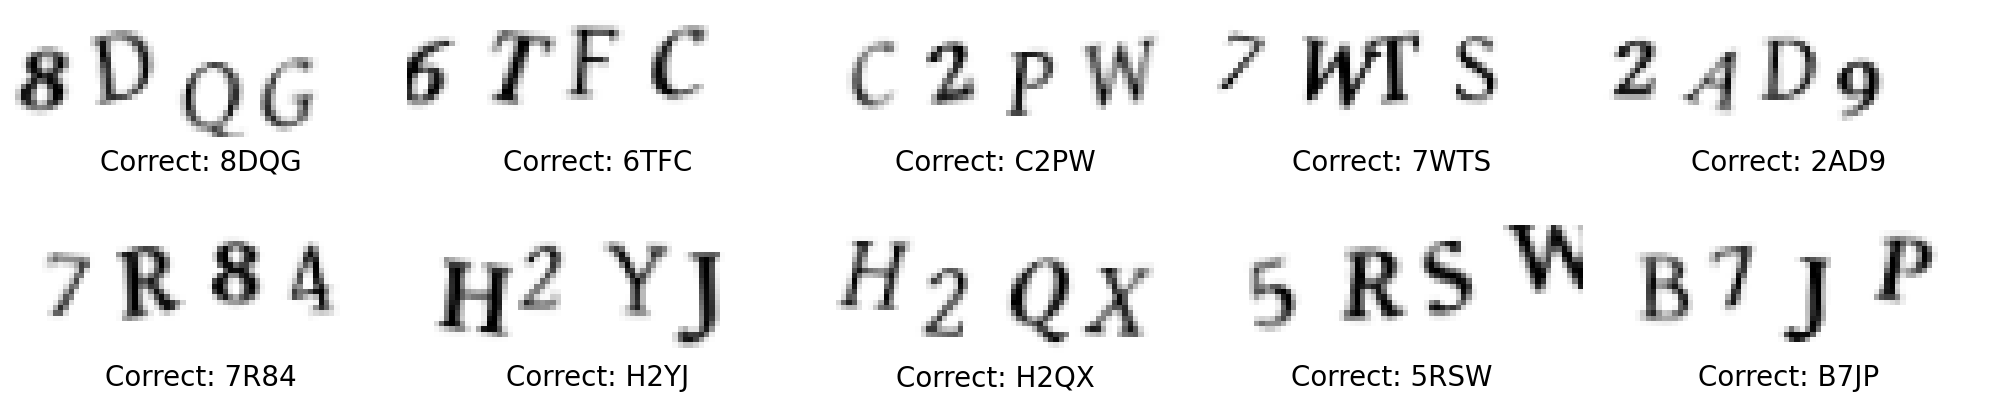

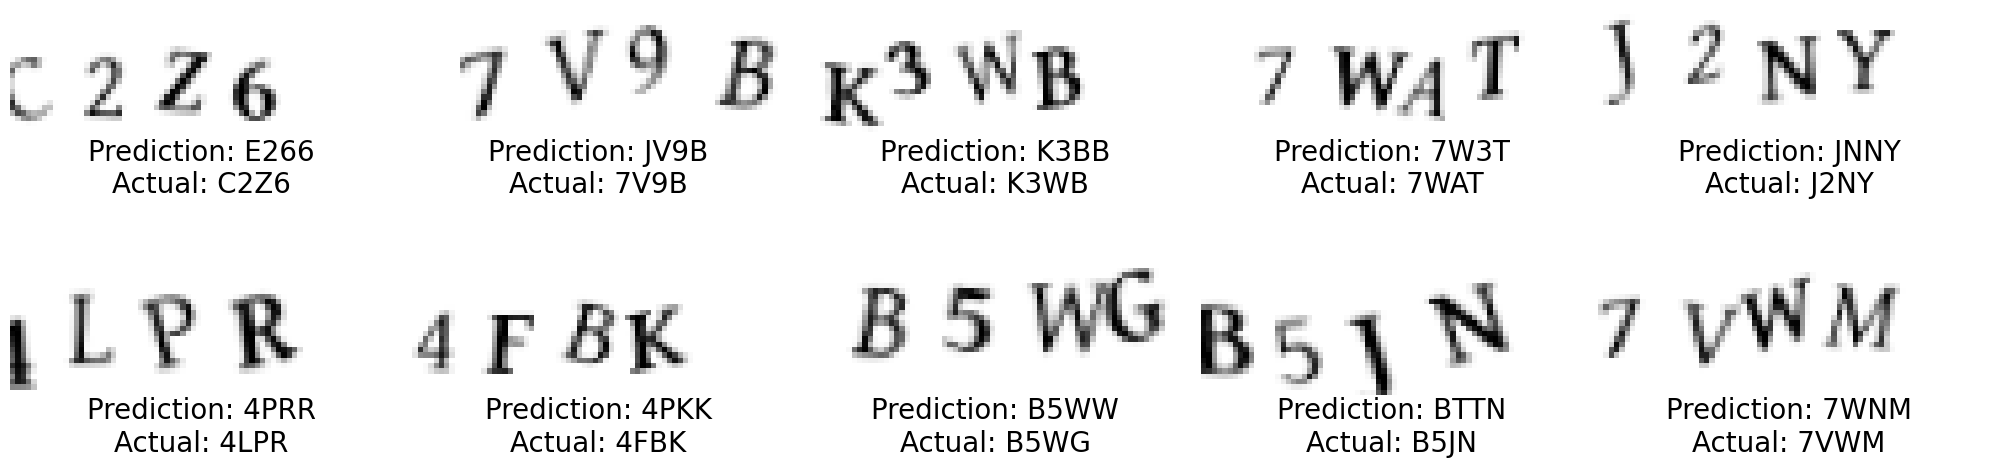

In [22]:
# Build evaluation dataset
dataset_eval = CAPTCHADataset(captcha_images_test, captcha_texts_test, captcha_transform)

# Evaluate the basic model
evaluate_model(model_basic, le, dataset_eval)

## Questions

1. What is the purpose and benefits of data augmentation?


Adds realistic variations (shift/rotate/scale/noise) to training images so the model sees more diversity. This reduces overfitting and improves generalization to new CAPTCHAs.

2. What is the purpose of 1\*1 convolution kernel?
   

Mixes information across channels at each pixel and can reduce/expand the number of channels. It’s a cheap way to change feature depth and add capacity without changing spatial size.

3. What is the purpose of dropout? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Randomly zeros some activations during training so the network can’t rely on a few neurons/features. It mainly improves generalization (less overfitting) and can make training noisier/slower rather than faster.

4. What is the purpose of batch normalization? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Normalizes activations using batch statistics to keep scales stable through the network. It mainly improves training stability and convergence (smoother gradients, allows higher learning rates) and can also give a small regularization effect.

## Improvements (Optional; Not Graded)

Like homework 1, **you can optionally choose to work on two improvements to the neural network model**, and see if these modifications help with the accuracy. Please note that we won't grade your solutions for these questions, but we may give you feedbacks should you choose to complete them. We also encourage you to **reuse previous code and functions** as much as possible, and avoid repeating identicial code from previous part of this homework.

***

   Neural network models are susceptible to over-fitting problems due to their huge amount of free parameters. When neural network model overfits, it performs extremely well on the training set, but can easily fail when new samples are added. There are three possible approaches to mitigate the over-fitting issue:

  * Adding regularization (L1 and/or L2) to parameters of each linear or convolution layer.
  * Adding dropout layers (`torch.nn.Dropout`) to the model.
  * Adding batch normalization layers (`torch.nn.BatchNorm2d`) to the model.
  
Try one or a few of these approaches and compare their performance with the original model. Complete the following tasks by adding code and text cells  above and compare their performance with the original model. Complete the following tasks by adding code and text cells below:
  
  * Specify your choice of approaches and the details for each approach:
    - For regularization, this is the type of regularization and regularization factor for each convolution and linear layer.
    - For dropout layers, specify the number, position and dropout rate of all dropout layers.
    - For batch normalization layers, specify the number and position of all batch normalization layers.
  * Plot the loss and accuracy for both training and validation set. Think about what curves to put on the same plot.
    - One idea is to put the same metric of all four models (basic model and three improvement models) for the same set (e.g. training set) on the same plot. In this case, you will get four plots in the end.
    - You don't need to include plots as images in the notebook. Instead, just provide the code that can plot these curves.
  * Finally, report the accuracy of all three improvement models on the test set.

## Submission

When you’re done, push this completed notebook (including all code and discussion answers) to your GitHub repo, then submit the repo link on the Canvas submission page.


## References

1. PyTorch API reference: https://pytorch.org/docs/stable/index.html
2. PyTorch Neural Network Modules: https://pytorch.org/docs/stable/nn.html
3. Over-fitting: https://en.wikipedia.org/wiki/Overfitting
4. Residual neural network: https://en.wikipedia.org/wiki/Residual_neural_network
5. Residual blocks - Building blocks of ResNet: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec